In [45]:
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np

from neo_ls_svm import NeoLSSVM

from utils.encoding import dummie2multilabel


import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [316]:
def calculate_metrics(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    
    # Calculate sensitivity (True Positive Rate)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Sensitivity:", sensitivity)
        
    return accuracy, recall, f1, sensitivity


# Load

In [317]:
# prefix = 'denoised'
prefix = 'noise_denoised'
# prefix = 'noised'

# feature_selected = False
feature_selected = True

if not feature_selected :
    prefix += '_no'

In [318]:
# normalize = False
# normalize = True

In [319]:
# scale = False
scale = True

In [320]:
df_train = pd.read_csv(f'Feature Selected\{prefix}_feature_selected_train.csv')
df_test = pd.read_csv(f'Feature Selected\{prefix}_feature_selected_test.csv')
df_test

,0,1,2,3,4,5,6,7,8,9,Final Label
0,149.330765,-102.180234,43.892594,-5.017802,0.826096,0.903049,1.050407,-0.799464,-0.633545,-0.137857,NRG
1,169.118900,73.211832,-74.972111,-7.399695,2.910872,0.899321,0.835612,-0.728216,-0.595483,-0.198452,NRG
2,158.660903,157.106027,13.141015,-8.573403,4.408988,-0.082771,0.930476,-0.732528,-0.696885,-0.190233,NRG
3,1259.778284,209.662458,-5.200208,-18.828063,9.791702,4.588684,0.560620,0.108653,-0.393131,0.261422,NRG
4,372.414373,-92.991815,-67.689439,-8.961394,3.557722,0.953817,0.933067,-0.587960,-0.491682,-0.065755,NRG
...,...,...,...,...,...,...,...,...,...,...,...
1535,497.552078,406.154750,-191.554946,-13.681246,7.462441,0.404976,0.585667,-0.364273,-0.383409,-0.045988,RG
1536,415.720471,-4.276191,-152.833739,-8.132492,3.576520,1.966457,0.852573,-0.515771,-0.498538,-0.037046,RG
1537,118.725544,44.150890,-52.054592,-7.094948,2.093595,-0.103950,0.878386,-0.817390,-0.590196,-0.243145,RG
1538,93.460828,78.007328,2.383241,-6.883363,3.261748,0.210086,1.029476,-0.841224,-0.738327,-0.265331,RG


In [321]:
df_train.loc[df_train['Final Label'] == 'RG', 'Final Label'] = 1 
df_train.loc[df_train['Final Label'] == 'NRG', 'Final Label'] = 0

df_test.loc[df_test['Final Label'] == 'RG', 'Final Label'] = 1
df_test.loc[df_test['Final Label'] == 'NRG', 'Final Label'] = 0

df_train['Final Label'].value_counts()

Final Label
0    2000
1    2000
Name: count, dtype: int64

# Split attribute and label

In [322]:
X_train = df_train.drop(columns=['Final Label'])
y_train = df_train['Final Label'].astype(int)

X_test = df_test.drop(columns=['Final Label'])
y_test = df_test['Final Label'].astype(int)

In [323]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
1535    1
1536    1
1537    1
1538    1
1539    1
Name: Final Label, Length: 1540, dtype: int32

# Normalize

In [324]:
normalizer = Normalizer()

if normalize :
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

# Scaler

In [325]:
# Initialize MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

if scale :
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Result List

In [326]:
result_list = []

# LS-SVM

In [327]:
model = NeoLSSVM(estimator_type="classifier").fit(X_train, y_train)

In [328]:
y_pred = model.predict(X_test)
y_pred

# Calculate metrics
accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)

# Append results to DataFrame
result_list.append(
    {
        'Method': 'NeoSVM',
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1, 
        'Sensitivity': sensitivity
})

result_list

Accuracy: 0.6772727272727272
Recall: 0.7025974025974026
F1 Score: 0.6852438252058265
Sensitivity: 0.7025974025974026


[{'Method': 'NeoSVM',
  'Accuracy': 0.6772727272727272,
  'Recall': 0.7025974025974026,
  'F1 Score': 0.6852438252058265,
  'Sensitivity': 0.7025974025974026}]

# SVC Scikit

In [329]:
# Define kernel types
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Initialize DataFrame to store results

# Iterate through different kernel types
for kernel in kernels:
    # Initialize SVC classifier with current kernel
    clf = SVC(kernel=kernel)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)  # Assuming X_train is also used for evaluation
    
    # Calculate metrics
    accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)
    
    result_list.append(
        {
            'Method': 'SVM ' + kernel, 
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1, 
            'Sensitivity': sensitivity
    })

Accuracy: 0.624025974025974
Recall: 0.6987012987012987
F1 Score: 0.6501510574018128
Sensitivity: 0.6987012987012987
Accuracy: 0.6655844155844156
Recall: 0.7545454545454545
F1 Score: 0.6929039952295767
Sensitivity: 0.7545454545454545
Accuracy: 0.6071428571428571
Recall: 0.7610389610389611
F1 Score: 0.6595385481148003
Sensitivity: 0.7610389610389611
Accuracy: 0.5493506493506494
Recall: 0.5805194805194805
F1 Score: 0.5629722921914359
Sensitivity: 0.5805194805194805


# KNN

In [330]:
neighbors = [10, 100, 500]

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    
    # Train the classifier
    if normalize or scale :
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)  
    else :
        knn.fit(X_train.values, y_train)
        y_pred = knn.predict(X_test.values)  
    
    # Calculate metrics
    accuracy, recall, f1, sensitivity = calculate_metrics(y_test, y_pred)
    
    # Append results to DataFrame
    result_list.append(
        {
            'Method': f'KNN {neighbor} neighbor', 
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1, 
            'Sensitivity': sensitivity
    })


Accuracy: 0.6402597402597403
Recall: 0.5532467532467532
F1 Score: 0.6059743954480795
Sensitivity: 0.5532467532467532
Accuracy: 0.6363636363636364
Recall: 0.6480519480519481
F1 Score: 0.6405648267008986
Sensitivity: 0.6480519480519481
Accuracy: 0.5967532467532467
Recall: 0.6311688311688312
F1 Score: 0.6101694915254237
Sensitivity: 0.6311688311688312


# Result

In [331]:
results_df = pd.DataFrame(result_list,columns=['Method', 'Accuracy', 'Recall', 'F1 Score', 'Sensitivity'])
results_df.to_csv('temp_result_machine_learning.csv')
results_df

,Method,Accuracy,Recall,F1 Score,Sensitivity
0,NeoSVM,0.677273,0.702597,0.685244,0.702597
1,SVM linear,0.624026,0.698701,0.650151,0.698701
2,SVM rbf,0.665584,0.754545,0.692904,0.754545
3,SVM poly,0.607143,0.761039,0.659539,0.761039
4,SVM sigmoid,0.549351,0.580519,0.562972,0.580519
5,KNN 10 neighbor,0.640260,0.553247,0.605974,0.553247
6,KNN 100 neighbor,0.636364,0.648052,0.640565,0.648052
7,KNN 500 neighbor,0.596753,0.631169,0.610169,0.631169


# Visualize result

In [34]:
all_results_df = pd.read_excel('Hasil Eksperimen.xlsx')
all_results_df

,Model,Dataset,Feature Selected,Normalize,Standardize,Accuracy,Recall,F1,Sensitivity
0,NeoSVM,noised,False,False,False,0.665584,0.642857,0.657807,0.642857
1,SVM linear,noised,False,False,False,0.612338,0.571429,0.595802,0.571429
2,SVM rbf,noised,False,False,False,0.564935,0.640260,0.595411,0.640260
3,SVM poly,noised,False,False,False,0.559091,0.789610,0.641689,0.789610
4,SVM sigmoid,noised,False,False,False,0.524026,0.511688,0.518080,0.511688
...,...,...,...,...,...,...,...,...,...
139,SVM poly,noise denoise,True,False,True,0.607143,0.761039,0.659539,0.761039
140,SVM sigmoid,noise denoise,True,False,True,0.549351,0.580519,0.562972,0.580519
141,KNN 10 neighbor,noise denoise,True,False,True,0.640260,0.553247,0.605974,0.553247
142,KNN 100 neighbor,noise denoise,True,False,True,0.636364,0.648052,0.640565,0.648052


In [32]:
def plot_metrics_result(df):
    # Plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = range(len(df))

    plt.bar(index, df['Accuracy'], bar_width, label='Accuracy')
    plt.bar([i + bar_width for i in index], df['Recall'], bar_width, label='Recall')
    plt.bar([i + 2*bar_width for i in index], df['F1'], bar_width, label='F1 Score')
    plt.bar([i + 3*bar_width for i in index], df['Sensitivity'], bar_width, label='Sensitivity')

    plt.xlabel('Model')
    plt.ylabel('Metrics')
    plt.title('Performance Metrics by Model')
    plt.xticks([i + 1.5*bar_width for i in index], df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
def plot_accross_dataset_result(df):
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=df)
    plt.title('Accuracy Score Across Datasets Grouped by Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [49]:
# plot_df = all_results_df[(all_results_df['Dataset'] == 'noise denoise') & (all_results_df['Feature Selected'] == True) & (all_results_df['Normalize'] == False) & (all_results_df['Standardize'] == True)]
plot_df = all_results_df[(all_results_df['Feature Selected'] == True) & (all_results_df['Normalize'] == False) & (all_results_df['Standardize'] == True)]
plot_df

,Model,Dataset,Feature Selected,Normalize,Standardize,Accuracy,Recall,F1,Sensitivity
40,NeoSVM,noised,True,False,True,0.667532,0.659740,0.664921,0.659740
41,SVM linear,noised,True,False,True,0.624675,0.671429,0.641439,0.671429
42,SVM rbf,noised,True,False,True,0.647403,0.651948,0.648998,0.651948
43,SVM poly,noised,True,False,True,0.612987,0.792208,0.671806,0.792208
44,SVM sigmoid,noised,True,False,True,0.501299,0.477922,0.489362,0.477922
45,KNN 10 neighbor,noised,True,False,True,0.617532,0.523377,0.577778,0.523377
46,KNN 100 neighbor,noised,True,False,True,0.624675,0.605195,0.617219,0.605195
47,KNN 500 neighbor,noised,True,False,True,0.585065,0.602597,0.592214,0.602597
88,NeoSVM,denoised,True,False,True,0.609091,0.609091,0.609091,0.609091
89,SVM linear,denoised,True,False,True,0.566234,0.597403,0.579345,0.597403


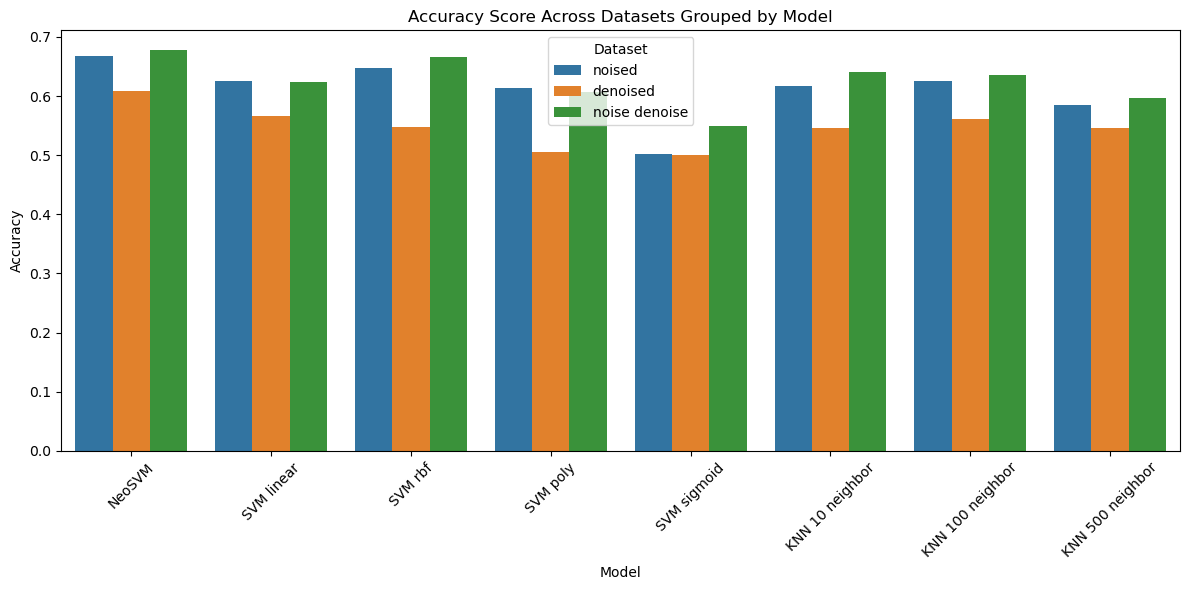

In [50]:
plot_accross_dataset_result(plot_df)

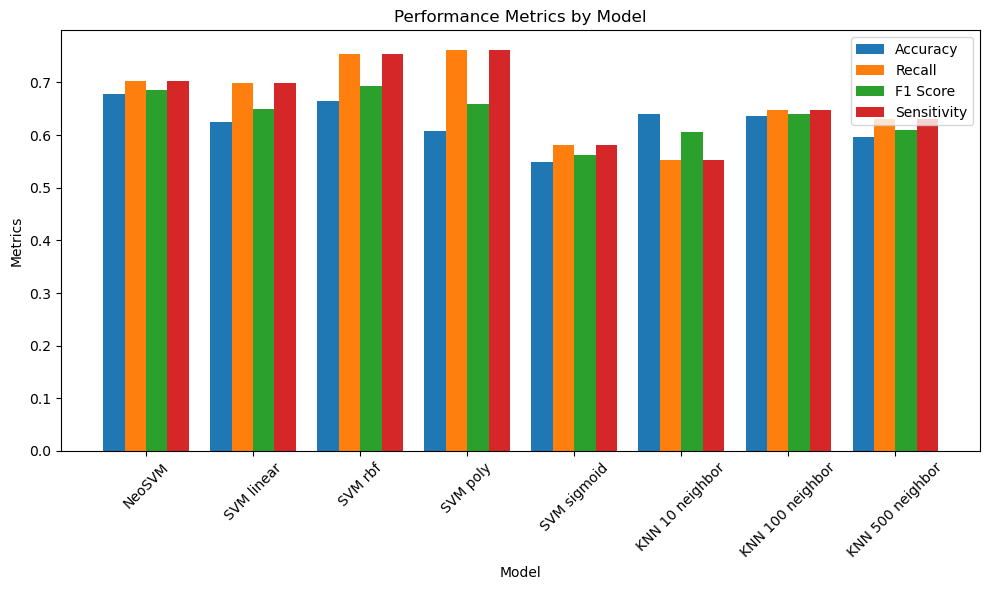

In [44]:
plot_metrics_result(plot_df)